## Project 4

The modules that will used in this report are imported. The working directory of the is notebook is also noted for later use as well.
<br>
Note: The ```DIR``` needs to ammended to the correct directory.

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dt_utils as dt

from scipy.special import erfinv
from scipy.integrate import quad
from iminuit import Minuit

from sklearn.utils import shuffle
from sklearn import model_selection, preprocessing
from sklearn.metrics import confusion_matrix, roc_curve

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

DIR = os.path.join(os.getcwd(),'Download')

### Setup

After importing the relevant modules for this project, the directory were the datafiles exist is defined and used to import the data into ```pandas.core.frame.DataFrame``` object.

Any ```NAN``` values are dropped to clean the dataset and avoid errors pertaining to the datatypes.
The datafiles for the bacground are concatinated into a signal dataframe and have isSignal = False

In [2]:
bkg1 = pd.read_csv(os.path.join(DIR, 'ggH1000.csv'))
bkg2 = pd.read_csv(os.path.join(DIR, 'Top.csv'))
bkg3 = pd.read_csv(os.path.join(DIR, 'Zjets.csv'))
sig = pd.read_csv(os.path.join(DIR, 'Diboson.csv'))

In [3]:
bkg1 = bkg1.dropna()
bkg2 = bkg2.dropna()
bkg3 = bkg3.dropna()
sig = sig.dropna()

In [4]:
background = pd.concat([bkg1, bkg2, bkg3], ignore_index=True)
background['isSignal'] = 0 # False
background = shuffle(background, random_state=42).reset_index(drop=True)

sig['isSignal'] = 1 # True
sig = shuffle(sig, random_state=42).reset_index(drop=True)

Here, a large dataframe is created with the data columns defined as the ```theKeys```

In [5]:
theKeys = [
    'lep1_pt', 'lep2_pt', 'fatjet_pt', 
    'fatjet_eta', 'fatjet_D2', 'Zll_mass',
    'Zll_pt', 'MET', 'reco_zv_mass', 
    'isSignal', 'FullEventWeight'
]

The overall dataset is created here by shuffling and combining the two. This dataset will be used to understand the properties and ranges of the variables.

In [6]:
dataset = pd.concat([sig, background], ignore_index=True)
dataset = shuffle(dataset, random_state=42).reset_index(drop=True)
dataset = pd.DataFrame(dataset, columns=theKeys)

dataset

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,403592.060,39689.440,952729.30,-0.172977,1.584759,88611.200,434785.10,29450.2070,1545223.60,0,1.580401
1,124436.510,99029.860,681191.30,1.219152,1.131244,90931.330,205520.52,25297.7900,1903609.40,0,0.797324
2,67434.695,63819.090,342487.03,0.963246,2.369773,94087.070,109228.33,16878.6210,417788.70,0,0.807570
3,436853.660,106951.930,577721.06,-1.245943,2.557409,91756.710,539646.10,37823.9140,1845224.80,0,0.821226
4,151129.600,46019.760,275881.34,-0.358881,2.059630,95254.710,196666.50,18130.4530,476962.16,0,0.852533
...,...,...,...,...,...,...,...,...,...,...,...
6876967,171614.720,80991.150,220306.44,0.834135,2.343589,88169.280,245690.44,2503.7637,533689.70,0,0.709959
6876968,167501.780,34231.200,210290.03,-0.039511,1.522134,89524.110,187603.34,15729.7350,424542.60,0,-0.806866
6876969,155184.190,26170.871,243494.19,-0.614308,0.852648,78219.740,170401.97,23925.4700,946753.44,0,0.749337
6876970,120845.820,67922.700,345129.75,1.196527,1.068891,146042.200,121867.12,25228.3030,486846.72,0,1.607120


Distribution cuts are applied for visualising where each of the properties has a unique distribution. However the analysis in this report is done for the full dataset unless where stated; the relevant cuts that are applied.
<br>
<br>
The data is corrected with ```FullEventWeight``` for the histogram. This scales the dataset either up or down on all the parameters

KeyboardInterrupt: 

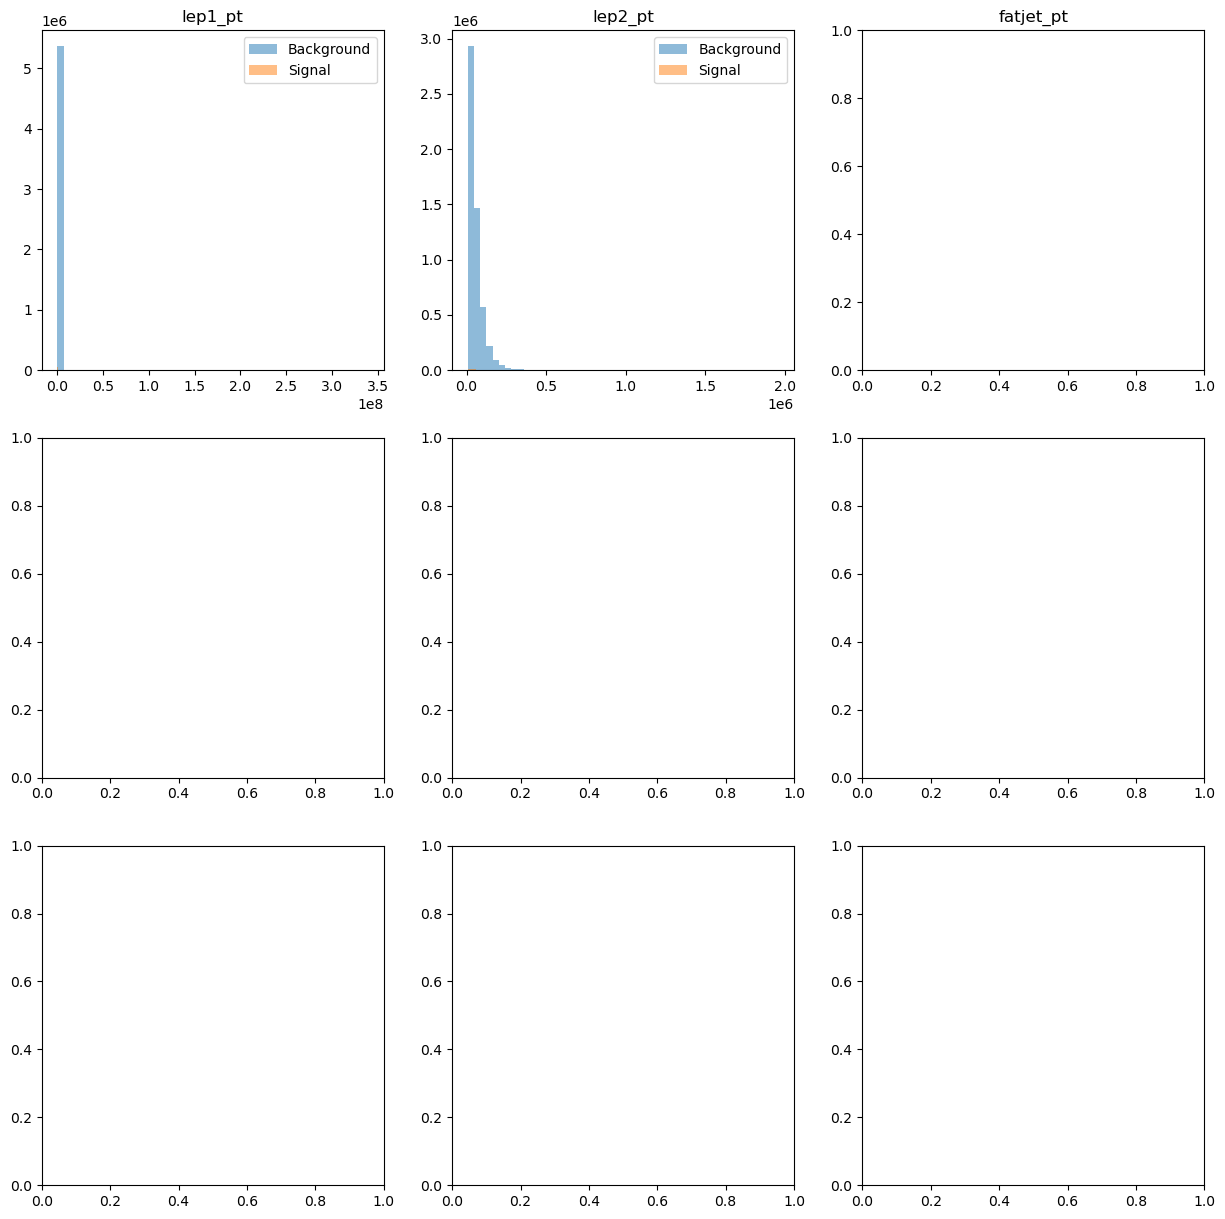

In [125]:
# Using plt.hist to plot the histograms of the variables in the dataset to see the distribution of the data for background and signal events
# The histograms are plotted for the variables 'lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET', 'reco_zv_mass'
# Use one plot for each variable and use different colors for background and signal events
# Make one figure with 3 rows and 3 columns
# The distributions of the data should be smooth lines with plt.hist
# Use 'FullEventWeight' to weight the events

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, key in enumerate(theKeys[:-2]):
    ax = axs[i//3, i%3]
    ax.set_title(key)
    ax.hist(dataset[dataset['isSignal'] == 0][key], bins=50, alpha=0.5, label='Background', weights=dataset[dataset['isSignal'] == 0]['FullEventWeight'])
    ax.hist(dataset[dataset['isSignal'] == 1][key], bins=50, alpha=0.5, label='Signal', weights=dataset[dataset['isSignal'] == 1]['FullEventWeight'])
    ax.legend()

plt.show()

In [11]:
# For the purposes of this plot, the wieghts are normalised because an array with all the values to be postive is expected.
normWeights = (dataset['FullEventWeight'] - dataset['FullEventWeight'].min())/(dataset['FullEventWeight'].max() - dataset['FullEventWeight'].min())

# Plot distributions for each feature in one figure
plt.figure(figsize=(20, 20))

for i, key in enumerate(theKeys):
    plt.subplot(4, 3, i+1)
        
    sns.kdeplot(x=dataset[dataset['isSignal']==0][key], label='Background', weights=normWeights[dataset['isSignal']==0])
    sns.kdeplot(x=dataset[dataset['isSignal']==1][key], label='Signal', weights=normWeights[dataset['isSignal']==1])
    plt.legend()

plt.show()

In [7]:
# Setting cuts
cuts = {
    'lep1_pt': (dataset['lep1_pt'] > 10000),
    'lep2_pt': None, #(dataset['lep2_pt'] < 300000)
    'fatjet_pt': (dataset['fatjet_pt'] > 150000),
    'fatjet_eta': None,
    'fatjet_D2': None, #(dataset['fatjet_D2'] < 3)
    'Zll_mass': None, #(dataset['Zll_mass'] < 50000)
    'Zll_pt': None, # (dataset['Zll_pt'] < 100000)
    'MET': None, # (dataset['MET'] < 200000)
    'reco_zv_mass': None, #(dataset['reco_zv_mass'] < 500000)
}

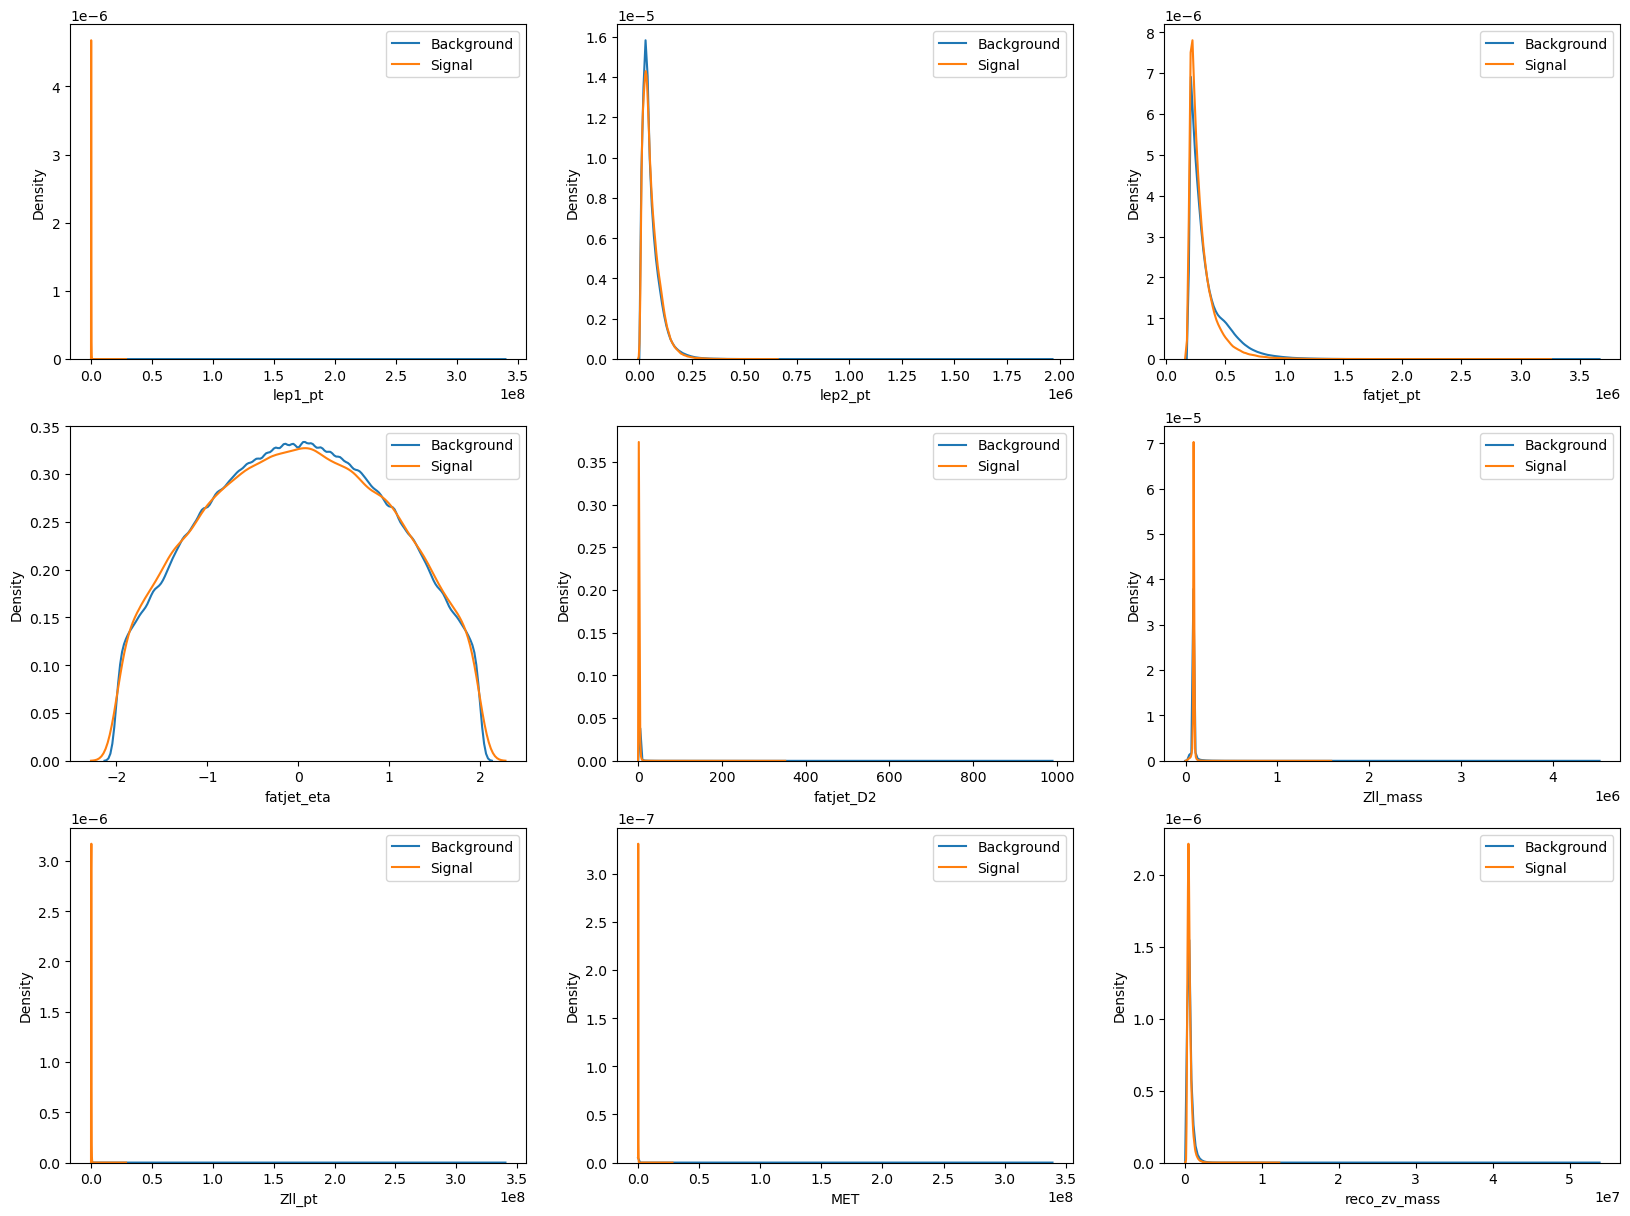

In [8]:
# Plot distributions for each feature in one figure
plt.figure(figsize=(20, 20))
for i, (key, cut) in enumerate(zip(theKeys, cuts.keys())):
    if key == 'reco_zv_mass':
        # apply all the cuts
        dset = copy.deepcopy(dataset)
        for cut in cuts.keys():
            if cuts[cut] is not None:
                dset = dset[cuts[cut]]

    elif cuts[cut] is not None:
        dset = dataset[cuts[cut]]

    else:
        dset = dataset

    # normalise the weights between 0 and 1
    normWeights = (dset['FullEventWeight'] - dset['FullEventWeight'].min())/(dset['FullEventWeight'].max() - dset['FullEventWeight'].min())
    
    plt.subplot(4, 3, i+1)

    sns.kdeplot(x=dset[dset['isSignal']==0][key], label='Background', weights=normWeights[dset['isSignal']==0])
    sns.kdeplot(x=dset[dset['isSignal']==1][key], label='Signal', weights=normWeights[dset['isSignal']==1])
    plt.legend()

plt.show()

To understand the invariant mass, a distribution plot of the ```reco_zv_mass``` variable is optained. The cuts that were applied previously to visualise the main distribution of the variables can now be used to examine how the dataset changes.
<br>
<br>
Create reco_zv_mass distributions for the combined background and signal samples, and integrate them to find the totalnumber of signal and background events before and after kinematic cuts

In [179]:
sig.shape[0]

155127

In [236]:
# Create and correct the dataset to have the best possible signal to background ratio
dataset = pd.concat([sig, background], ignore_index=True)
dataset = shuffle(dataset, random_state=42).reset_index(drop=True)
dataset = pd.DataFrame(dataset, columns=theKeys)

print("Original\nTotal number of events:", len(dataset), "\nSignal Events:", len(dataset[dataset['isSignal']==1]),
        "\nBackground events:", len(dataset[dataset['isSignal']==0]))

# Same cuts as before
cuts = {
    'lep1_pt': (dataset['lep1_pt'] > 10000),
    'lep2_pt': None, #(dataset['lep2_pt'] < 300000)
    'fatjet_pt': (dataset['fatjet_pt'] > 150000),
    'fatjet_eta': None,
    'fatjet_D2': None, #(dataset['fatjet_D2'] < 3)
    'Zll_mass': None, #(dataset['Zll_mass'] < 50000)
    'Zll_pt': None, # (dataset['Zll_pt'] < 100000)
    'MET': None, # (dataset['MET'] < 200000)
    'reco_zv_mass': None, #(dataset['reco_zv_mass'] < 500000)
}

# Applying only select cuts
cuts_to_apply = ['fatjet_pt']

for cut in cuts:
    if cuts[cut] is not None:
        dataset = dataset[cuts[cut]]

# cutdataset = cutdataset[cutdataset['reco_zv_mass'] > 0.8e6]
# cutdataset = cutdataset[cutdataset['reco_zv_mass'] < 1.4e6]

print("\nNew\nTotal number of events:", len(dataset), "\nSignal Events:", len(dataset[dataset['isSignal']==1]), 
      "\nBackground events:", len(dataset[dataset['isSignal']==0]))

Original
Total number of events: 6876972 
Signal Events: 155127 
Background events: 6721845


C:\Users\s1967975\AppData\Local\Temp\ipykernel_17968\2386452937.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset = dataset[cuts[cut]]
C:\Users\s1967975\AppData\Local\Temp\ipykernel_17968\2386452937.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset = dataset[cuts[cut]]
C:\Users\s1967975\AppData\Local\Temp\ipykernel_17968\2386452937.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset = dataset[cuts[cut]]
C:\Users\s1967975\AppData\Local\Temp\ipykernel_17968\2386452937.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset = dataset[cuts[cut]]



New
Total number of events: 51545 
Signal Events: 726 
Background events: 50819


C:\Users\s1967975\AppData\Local\Temp\ipykernel_17968\2386452937.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset = dataset[cuts[cut]]
C:\Users\s1967975\AppData\Local\Temp\ipykernel_17968\2386452937.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset = dataset[cuts[cut]]
C:\Users\s1967975\AppData\Local\Temp\ipykernel_17968\2386452937.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset = dataset[cuts[cut]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


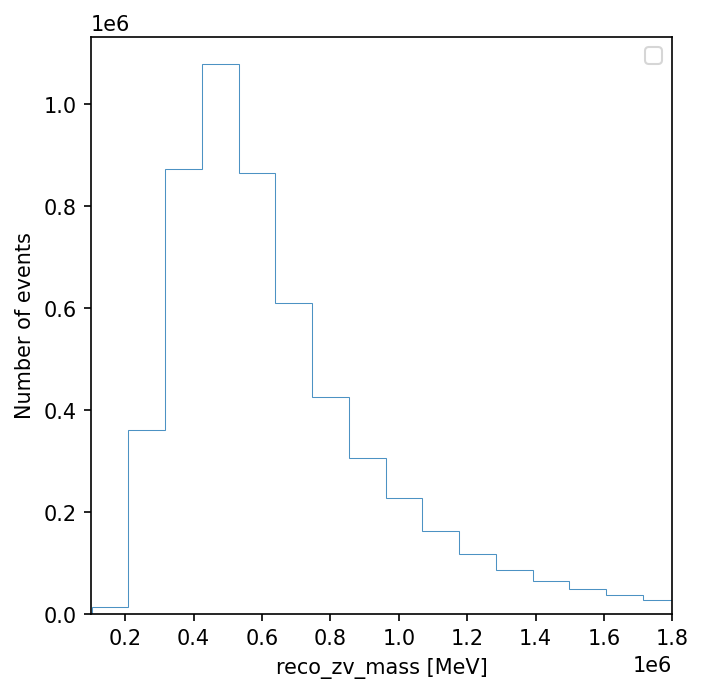

In [9]:
cutdataset = dataset

# Creating a histogram of the 'reco zv mass' variable for all events
BINS = 500
plt.figure(dpi=150, figsize=(5, 5))

#normWeights = (cutdataset['FullEventWeight'] - cutdataset['FullEventWeight'].min())/(cutdataset['FullEventWeight'].max() - cutdataset['FullEventWeight'].min())
normWeights = cutdataset['FullEventWeight'] 

plt.hist(cutdataset['reco_zv_mass'], bins=BINS, alpha=0.8, histtype='step', linewidth=0.5, weights=normWeights)
# plt.hist(cutdataset[cutdataset['isSignal']==0]['reco_zv_mass'], bins=BINS, alpha=0.8, label='Background', histtype='step', weights=normWeights[cutdataset['isSignal']==0], linewidth=0.5)
# plt.hist(cutdataset[cutdataset['isSignal']==1]['reco_zv_mass'], bins=BINS, alpha=0.8, label='Signal', histtype='step', weights=normWeights[cutdataset['isSignal']==1], linewidth=0.5)

plt.xlim(0.1e6, 1.8e6)
plt.ylim(0, )

leg = plt.legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.xlabel('reco_zv_mass [MeV]')
plt.ylabel('Number of events')
plt.show()

### Fitting and hypothesis-testing
Classes are created to manage and understand the eqautions that would best describe the signal and background event in the dataset. A polynomial distribution would be assumed for the background event and a gaussian for the events that known as the signal. Another class is created to understand both the signal and the background in the overall distribtion

In [187]:
# Creating a polynomial distribution class to map the background events
class polynomial:
    def __init__(self, coefficients):
        self.poly = np.poly1d(coefficients)
        
    def evaluate(self, x):
        return self.poly(x)



# Creating a gaussian distribution class to map the signal events
class gaussian:
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma
        
    def evaluate(self, x):
        return np.exp(-0.5*((x - self.mean)/self.sigma)**2)/(self.sigma*np.sqrt(2*np.pi))

A function is created to extract the x and y datapoints of a histogram. This is done to make it easier select datapoints from the binned dataset

In [188]:
def get_hist_info(data, NBINS=100, weights=None):
    # Derive the appropriate numbers in the data
    # Here shifting x values to the center of the bins and
    # getting the height of the bin for y values
    
    n, bins = np.histogram(data, bins=NBINS, weights=weights)
    bins = [(bins[i] + bins[i+1])//2. for i in range(len(bins)-1)]
    return bins, n

Understanding the Null Hypothesis (H0) by considering only a polynomial model for all event. In this senario, we are only pretending that there is no signal detected.

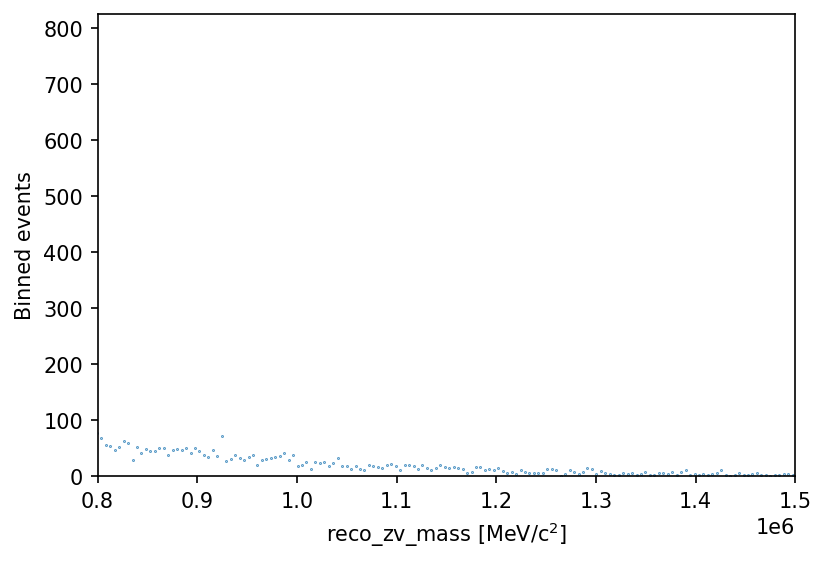

In [189]:
# # Set initial parameters for the signal and background distributions
# signal_model = gaussian(mean=1.2e6, std=0.1e6, weights=cutdataset[cutdataset['isSignal']==1]['FullEventWeight'])
# background_model = polynomial(coefficients=[-1e-6, 1e-3, 1], weights=cutdataset[cutdataset['isSignal']==0]['FullEventWeight'])

histdata = get_hist_info(cutdataset['reco_zv_mass'], NBINS=BINS, weights=cutdataset['FullEventWeight'])

plt.figure(dpi=150, figsize=(6, 4))
plt.scatter(histdata[0], histdata[1], label='Data', s=0.1)

plt.xlim(0.8e6, 1.5e6)
plt.ylim(0, )
plt.xlabel(r'reco_zv_mass [MeV/c$^2$]')
plt.ylabel('Binned events')

plt.show()

In [190]:
# save x and y values for x data between the range of 0.7e6, 1.3e6
cutdataset = cutdataset[cutdataset['reco_zv_mass'] > 0.7e6]
cutdataset = cutdataset[cutdataset['reco_zv_mass'] < 1.3e6]

x_data = np.array(histdata[0])
y_data = np.array(histdata[1])

mask = (x_data > 0.7e6) & (x_data < 1.3e6)
x_data = x_data[mask]
y_data = y_data[mask]

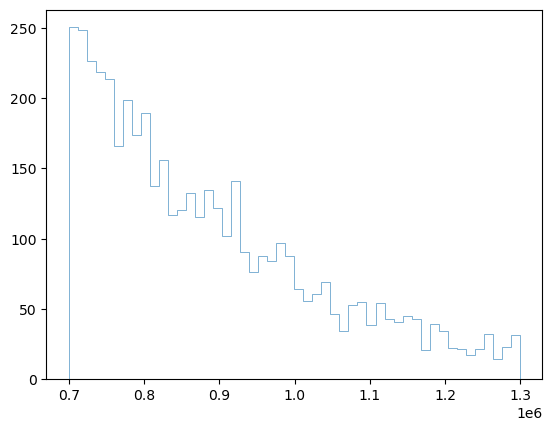

In [192]:
BINS = 50
plt.hist(cutdataset['reco_zv_mass'], bins=BINS, alpha=0.8, histtype='step', linewidth=0.5, weights=cutdataset['FullEventWeight'])
plt.show()

In [ ]:
# Find the sum of the weights for each bin and the number of events in each bin
def get_bin_weights(data, bins, weights):
    no_events = []
    bin_weights = []

    for i in range(len(data)//bins):
        data_mask = data[i*bins:((i+1)*bins)-1]
        weight_mask = weights[i*bins:((i+1)*bins)-1]

        no_events.append(len(data_mask))
        bin_weights.append(np.sum(weight_mask))

        # bin_weights.append(np.sum(weights[mask]))
    return np.array(no_events), np.array(bin_weights)

# Get the bin weights for the data
no_events, bin_weights = get_bin_weights(cutdataset['reco_zv_mass'], BINS, cutdataset['FullEventWeight'])

In [ ]:
bin_weights.max(), bin_weights.argmax()

(140.0332510362, 63)

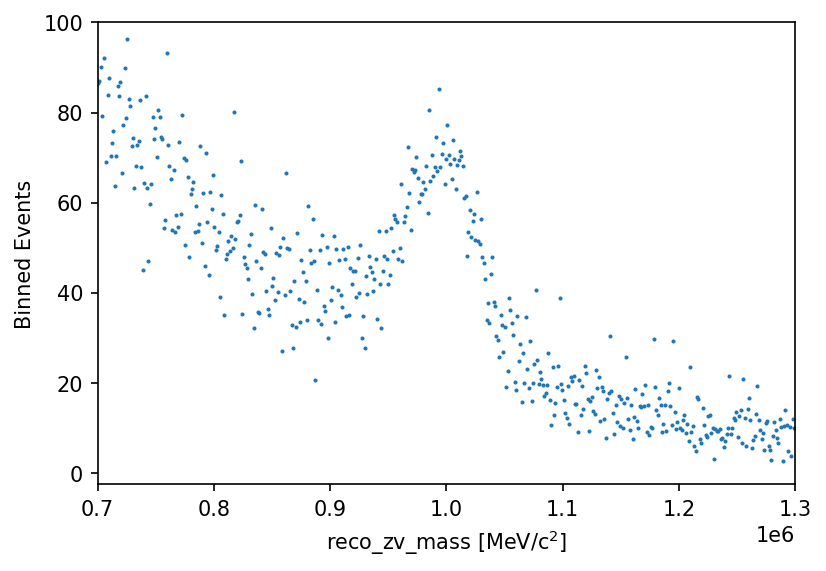

In [ ]:
plt.figure(dpi=150, figsize=(6, 4))
plt.scatter(x_data, y_data, label='Data', s=0.9)

plt.xlim(0.7e6, 1.3e6)
plt.ylim(-2.5, 100)
plt.xlabel(r'reco_zv_mass [MeV/c$^2$]')
plt.ylabel('Binned Events')

plt.show()

A small signal can be seen at a invariant mass of 1 TeV/c^2

In [ ]:
N_obs = np.sum(cutdataset['FullEventWeight'])
std_dev_2 = np.sum(np.square(cutdataset['FullEventWeight']))

In [ ]:
def min_chi2_H0(a, b, c, d, e): #, d, e, f, g
    # Defined a Minuit specific funtion for chi^2 minimisation
    # dor null Hypothesis only, therefore set with only linear model
    
    model = polynomial(coefficients=[a, b, c, d, e]) #d, e, f, g

    total = 0.
    for x, N_obs, bin_w in zip(x_data, y_data, bin_weights):
        N_exp = model.evaluate(x)

        total += np.square(N_obs-N_exp)/bin_w
    return total

# Set intial parameters for the distribution
a = 1.5
b = -8.8
c = 0.1
d = -0.1
e = -0.01
f = -0.006
g = 1

startvals_H0 = {
    'a': a,
    'b': b,
    'c': c,
    'd': d,
    'e': e,
    # 'f': f,
    # 'g': g
}

H0 = Minuit(min_chi2_H0, **startvals_H0)
H0.migrad()  # find minimum
H0.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.328e+30                  │              Nfcn = 492              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │-5.1762e-7 │    nan    │            │            │         │         │       │
│ 1 │ b    │ 6.3463e-1 │    nan    │            │            │         │         │       │
│ 2 │ c    │ -1.4047e3 │    nan    │            │            │         │         │       │
│ 3 │ d    │-1.3776e11 │    nan    │            │            │         │         │       │
│ 4 │ e    │   -1e-2   │    nan    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────┐
│   │   a   b   c   d   e │
├───┼─────────────────────┤
│ a │ nan nan nan nan nan │
│ b │ nan nan nan nan nan │
│ c │ nan nan nan nan nan │
│ d │ nan nan nan nan nan │
│ e │ nan nan nan nan nan │
└───┴─────────────────────┘

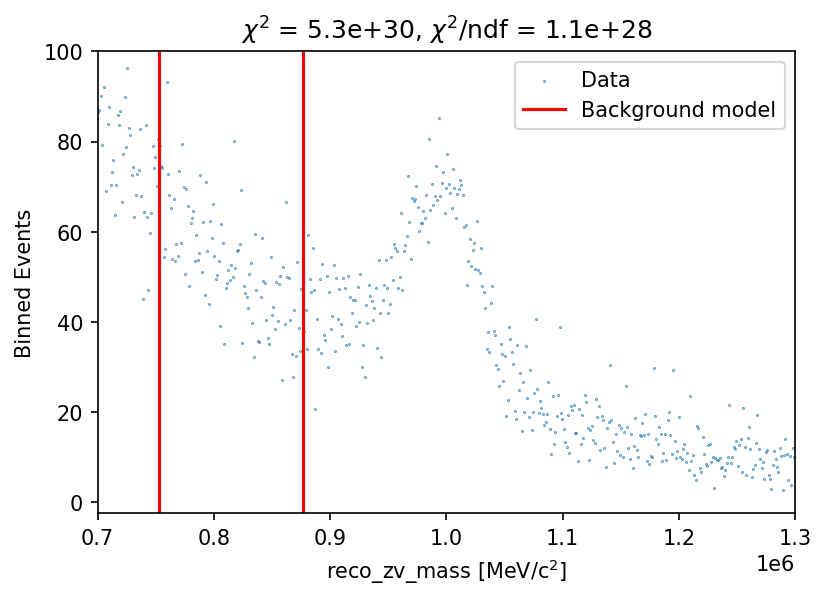

In [ ]:
bkg_fn = polynomial(H0.values)

# Plot the background model
plt.figure(dpi=150, figsize=(6, 4))

plt.scatter(x_data, y_data, label='Data', s=0.1)
plt.plot(x_data, bkg_fn.evaluate(x_data), label='Background model', color='red')

# Show the chi2 value
chi2 = H0.fval
ndf = len(x_data) - 5
chi2_ndf = chi2/ndf
plt.title(r'$\chi^2$ = {:.2g}, $\chi^2$/ndf = {:.2g}'.format(chi2, chi2_ndf))

plt.xlim(0.7e6, 1.3e6)
plt.ylim(-2.5, 100)

plt.xlabel(r'reco_zv_mass [MeV/c$^2$]')
plt.ylabel('Binned Events')

plt.legend()
plt.show()

In [ ]:
def see_fit_H0(args):
    fn = polynomial(args)
    plt.scatter(x_data, y_data, label='Data', s=0.1)
    plt.plot(x_data, fn.evaluate(x_data), label='Background model', color='red')

    chi2 = H0.fval
    ndf = len(x_data) - 5
    chi2_ndf = chi2/ndf

    plt.title(r'$\chi^2$ = {:.2g}, $\chi^2$/ndf = {:.2g}'.format(chi2, chi2_ndf))

    # plt.xlim(0.7e6, 1.3e6)
    # plt.ylim(-2.5, 100)

def see_fit_H1(args):
    bkg_fn = polynomial([args[0], args[1]])
    sig_fn = gaussian(args[2], args[3])

    plt.scatter(x_data, y_data, label='Data', s=0.1)
    plt.plot(x_data, (((args[-1]-1)*bkg_fn.evaluate(x_data)) + args[-1]*(sig_fn.evaluate(x_data))), color='red')
    
    # chi2 = H1.fval
    # ndf = len(x_data) - 5
    # chi2_ndf = chi2/ndf

    # plt.title(r'$\chi^2$ = {:.2g}, $\chi^2$/ndf = {:.2g}'.format(chi2, chi2_ndf))

    # plt.xlim(0.7e6, 1.3e6)
    # plt.ylim(-2.5, 100)

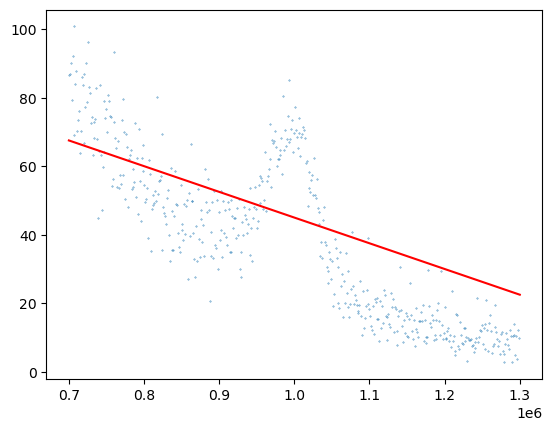

In [ ]:
sig_fn = gaussian(1e6, 8000)
bkg_fn = polynomial([-0.00005, 80])

plt.scatter(x_data, y_data, label='Data', s=0.1)
x_ = np.linspace(0.7e6, 1.3e6, 10000)
s = 2.5
plt.plot(x_, (((s-1)*bkg_fn.evaluate(x_)) + s*(sig_fn.evaluate(x_))), label='Background model', color='red')
plt.show()


In [ ]:
def min_chi2_H1(a, b, mean, sigma, sig_frac):
    # Defined a Minuit specific funtion for chi^2 minimisation  
    # for alternative Hypothesis only, therefore set with linear + guassian model
    
    bkg = polynomial(coefficients=[a, b])
    sig = gaussian(mean=mean, sigma=sigma)

    total = 0.
    for x, N_obs, bin_w in zip(x_data, y_data, bin_weights):
        N_exp = ((sig_frac-1)*bkg.evaluate(x)) + sig_frac*sig.evaluate(x)

        #total += (N_exp - N_obs + (N_obs*np.log(N_obs/N_exp)))
        total += np.square(N_obs-N_exp)/bin_w
    return total

# Set intial parameters for the distribution
a = -0.00005
b = 80
mean = 1e6
sigma = 8000
sig_fn = 2.5

startvals_H1 = {
    'a': a,
    'b': b,
    'mean': mean,
    'sigma': sigma,
    'sig_frac': sig_fn
}

H1 = Minuit(min_chi2_H1, **startvals_H1)
#H1.visualize(see_fit)
H1.migrad()  # find minimum
H1.hesse()

H1.interactive(plot=see_fit_H1)

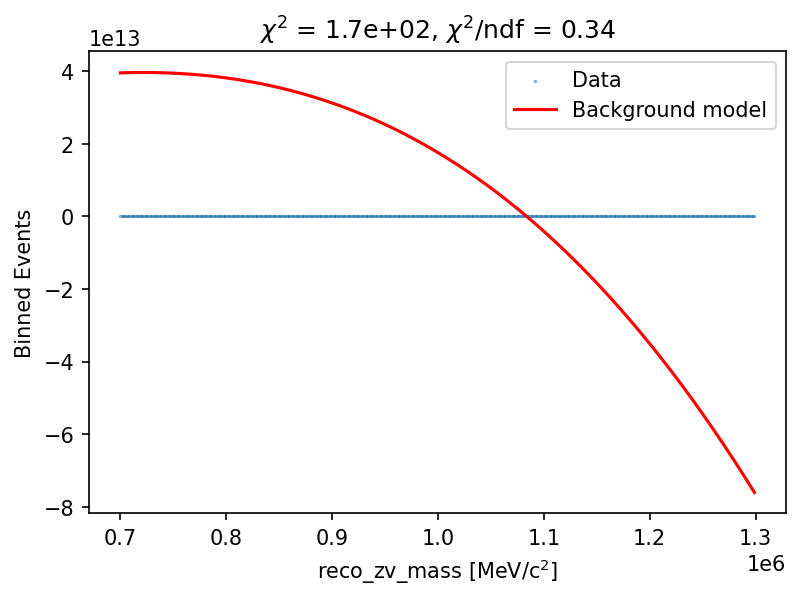

In [ ]:
bkg_fn = polynomial(H0.values)

# Plot the background model
plt.figure(dpi=150, figsize=(6, 4))

plt.scatter(x_data, y_data, label='Data', s=0.1)
plt.plot(x_data, bkg_fn.evaluate(x_data), label='Background model', color='red')

# Show the chi2 value
chi2 = H0.fval
chi2_ndf = chi2/(len(x_data) - 4)
plt.title(r'$\chi^2$ = {:.2g}, $\chi^2$/ndf = {:.2g}'.format(chi2, chi2_ndf))

# plt.xlim(0.7e6, 1.3e6)
# plt.ylim(-2.5, 100)

plt.xlabel(r'reco_zv_mass [MeV/c$^2$]')
plt.ylabel('Binned Events')

plt.legend()
plt.show()

# Creating a histogram of the 'reco zv mass' variable for all events
BINS = 5000
plt.figure(dpi=150, figsize=(6, 6))

normWeights = (cutdataset['FullEventWeight'] - cutdataset['FullEventWeight'].min())/(cutdataset['FullEventWeight'].max() - cutdataset['FullEventWeight'].min())

plt.hist(cutdataset['reco_zv_mass'], bins=BINS, alpha=0.8, histtype='step')
plt.hist(cutdataset[cutdataset['isSignal']==0]['reco_zv_mass'], bins=BINS, alpha=0.8, label='Background', histtype='step', weights=normWeights[cutdataset['isSignal']==0])
plt.hist(cutdataset[cutdataset['isSignal']==1]['reco_zv_mass'], bins=BINS, alpha=0.8, label='Signal', histtype='step', weights=normWeights[cutdataset['isSignal']==1])

plt.xlim(0, 3000000)
#plt.yscale('log')
leg = plt.legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.xlabel('reco_zv_mass')
plt.ylabel('Number of events')
plt.show()

In [ ]:
print("The total number of events in the dataset is:", len(cutdataset), ", of which", len(cutdataset[cutdataset['isSignal']==1]), "are signal events and", len(cutdataset[cutdataset['isSignal']==0]), "are background events.")

The total number of events in the dataset is: 232690 , of which 155127 are signal events and 77563 are background events.


### Employing a NN classifier

In [ ]:
input_features = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET']
target = 'isSignal'

Creating a new dataset with the selected features from training

In [ ]:
dataset = pd.concat([sig, background[:sig.shape[0]]], ignore_index=True)
dataset = shuffle(dataset, random_state=42).reset_index(drop=True)
dataset

,Unnamed: 0,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,13175,0.254105,22829.855,1,94981.970,369698.800,0.099988,1.428033,409203.80,0.708964,...,-0.968251,-0.918649,288481.440,146230.3400,1,-1.022872,-0.333399,93118.630,970268.00,999998.30
1,67930,0.780064,93162.860,0,52187.770,31518.734,0.193942,0.733512,473492.80,1.449307,...,-0.031548,-0.604845,30666.977,31646.7540,-1,0.472309,1.413699,28417.572,230479.64,-1.00
2,152601,1.657435,25608.209,1,87923.230,196946.780,0.035281,7.202905,203596.52,-0.011106,...,1.351873,2.000636,194285.480,9941.9795,-1,-0.102169,0.677845,9890.314,506476.44,572526.20
3,104042,0.054937,38425.098,0,90964.040,114010.120,0.047726,51.829220,590576.06,0.351441,...,-1.828445,0.295188,92993.290,34585.5230,1,-0.490096,-0.640138,30810.451,793679.40,873834.00
4,54609,0.759913,51400.914,0,102696.230,98407.430,0.103823,2.519282,1212429.50,-1.894481,...,-0.399442,1.881560,64410.500,72889.7200,-1,0.527516,-3.009940,63804.348,667269.25,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310249,119879,-0.854280,24006.777,0,88037.040,156688.020,0.143762,1.556505,210489.20,-0.179533,...,0.388441,-2.304606,156096.030,36061.6600,1,1.910536,-0.757135,10445.477,405252.03,415763.72
310250,54038,0.865879,45241.234,0,41240.645,46625.457,0.159541,0.905268,295430.50,0.306847,...,2.090148,2.058590,46526.402,17585.3610,-1,1.062679,-2.546058,10856.160,357405.90,-1.00
310251,131932,0.156935,2927.014,1,90309.664,255042.580,0.095527,0.510641,342996.34,-0.860783,...,-0.005890,1.561058,198528.300,72070.0550,1,0.082637,2.331021,71824.680,570416.00,592361.94
310252,146867,0.317182,8810.546,1,97334.170,210290.620,0.152452,0.630279,617749.30,1.669903,...,1.083420,1.546264,111056.180,121781.0200,1,0.461157,2.169874,109887.766,517904.70,514216.56


In [ ]:
input_dataset = dataset[input_features]
input_dataset = input_dataset[input_dataset['fatjet_pt'] > 150000]

traget_dataset = dataset[target]
traget_dataset = traget_dataset[input_dataset['fatjet_pt'] > 150000]

In [ ]:
## SANITY CHECK ##
# Checking if the number of signal and background events are equal
n_signal = len(traget_dataset[traget_dataset == 1])
n_background = len(traget_dataset[traget_dataset == 0])

print("The total number of events in the dataset is", len(traget_dataset), ", of which", n_signal, "are signal events and", n_background, "are background events.")

The total number of events in the dataset is 310254 , of which 155127 are signal events and 155127 are background events.


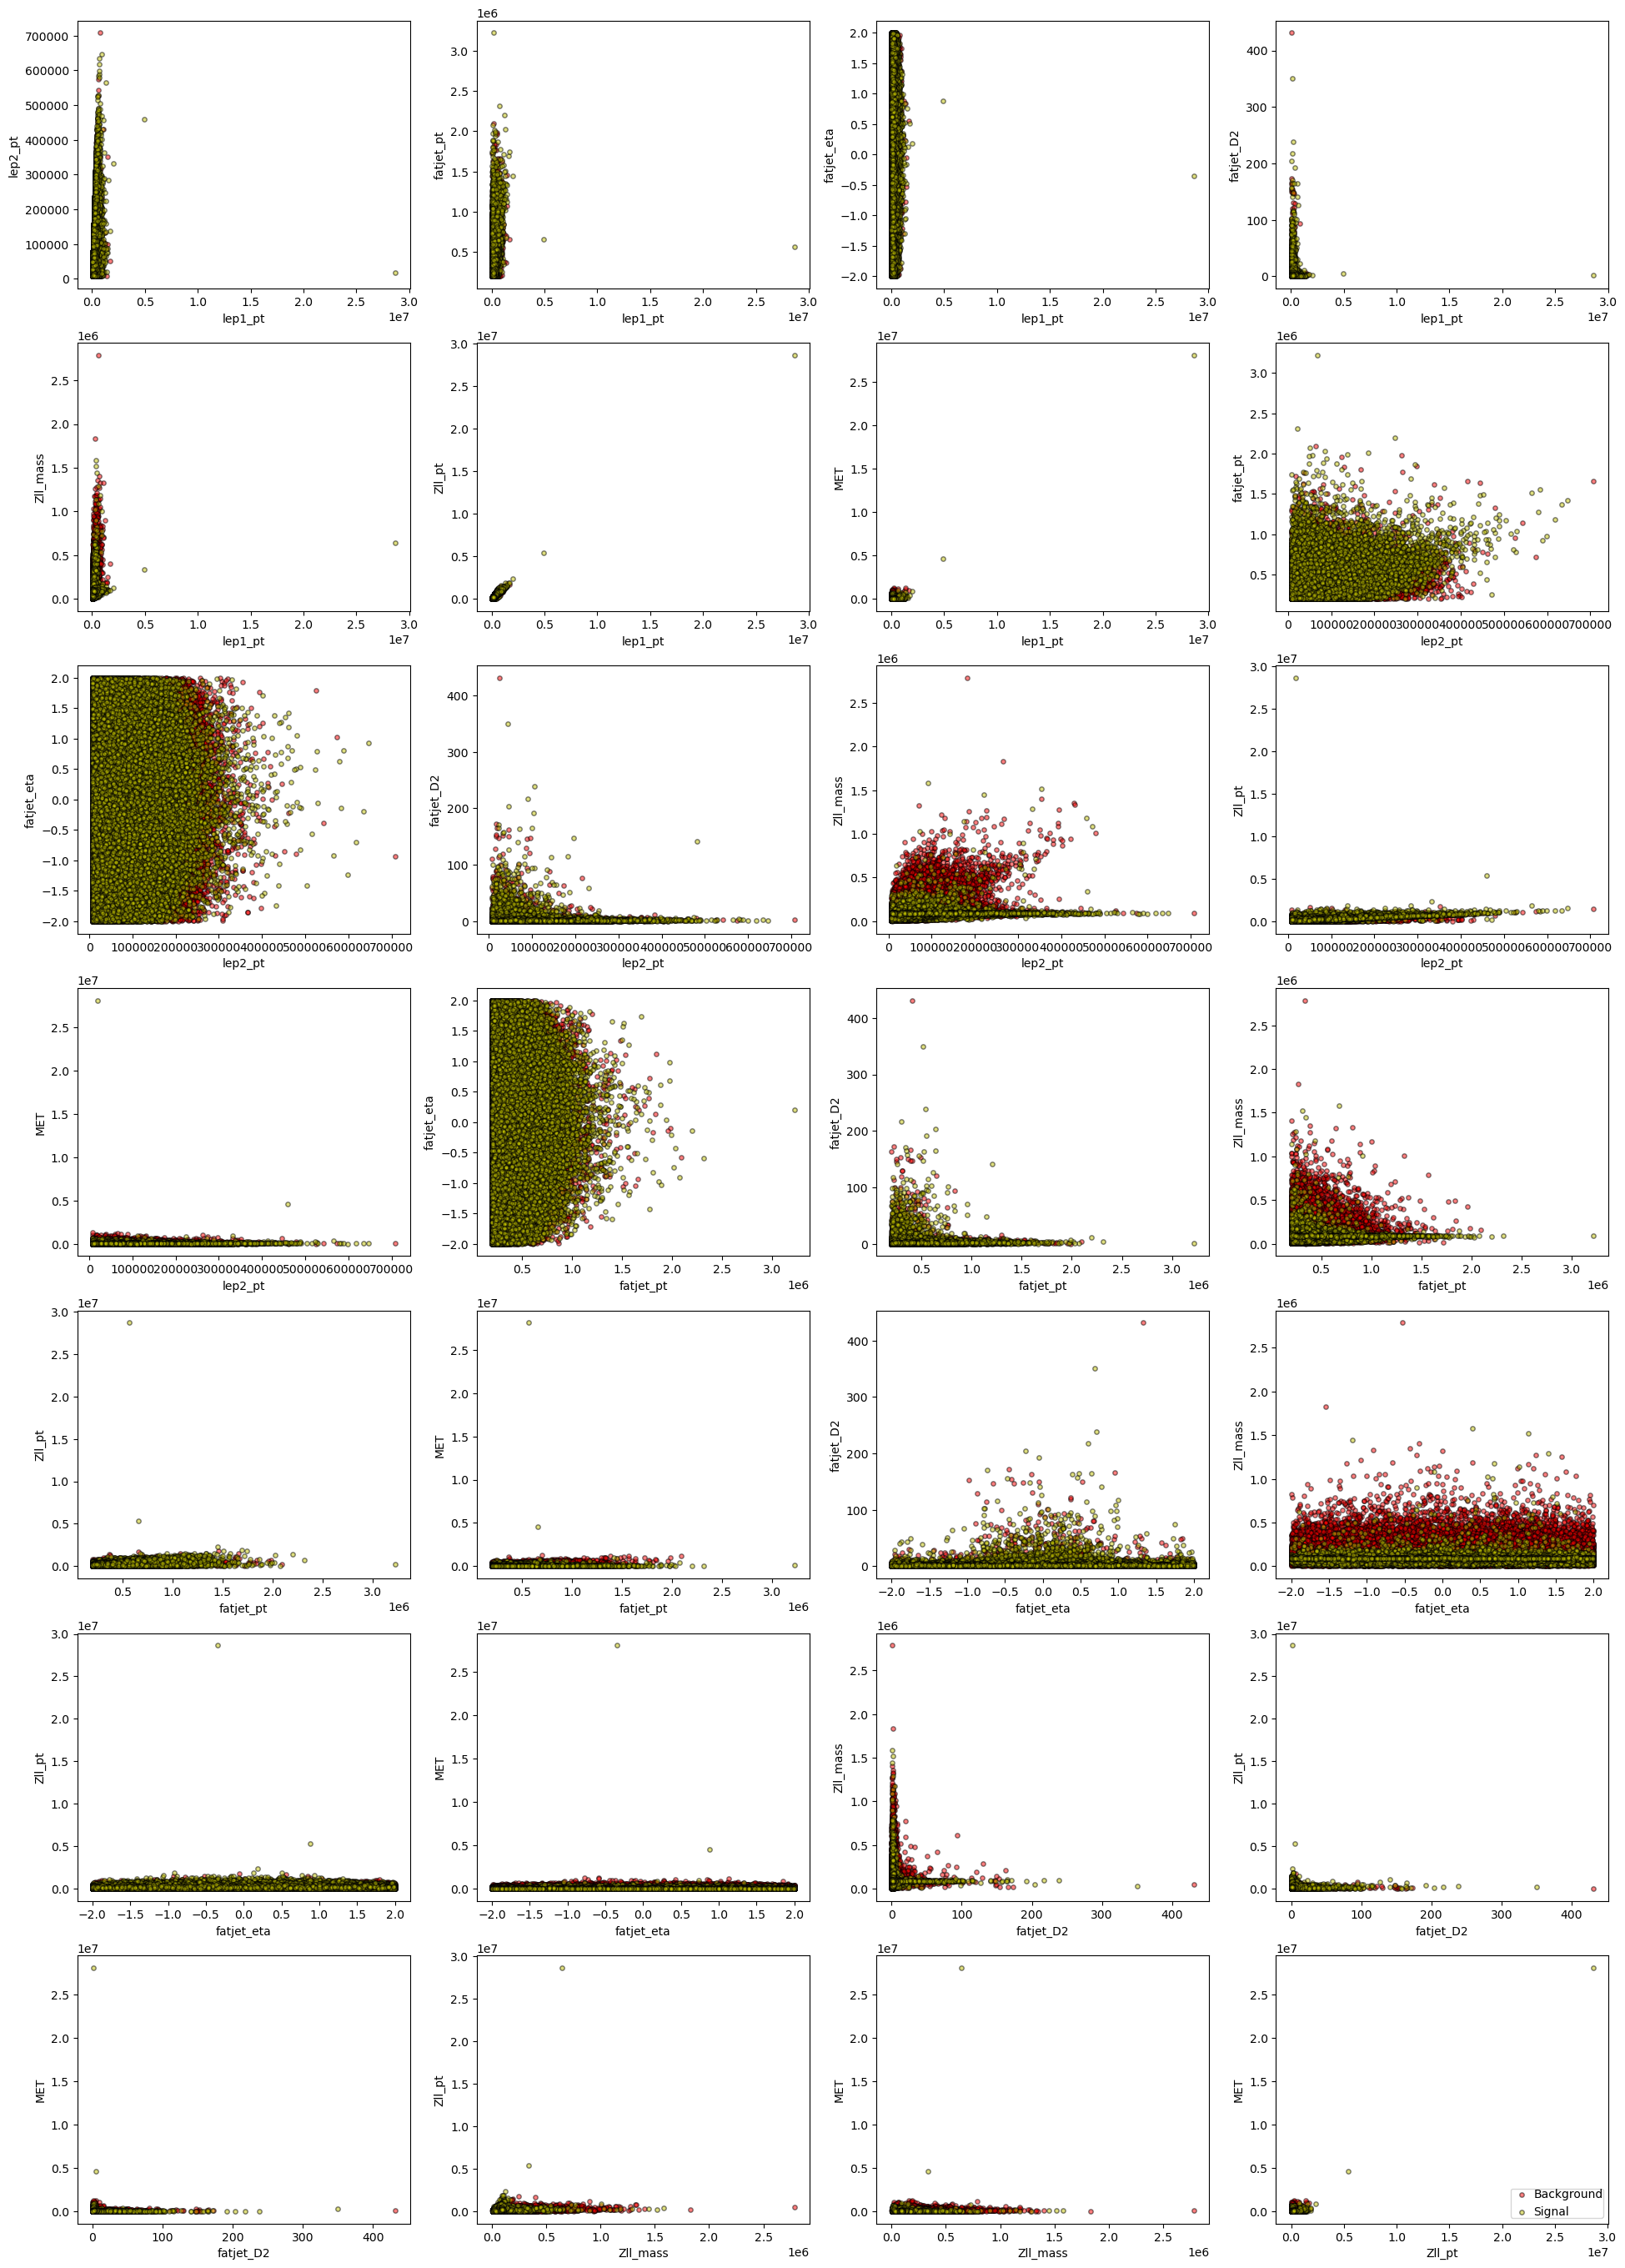

In [ ]:
dt.featureplot(input_dataset.values, dataset['isSignal'].values, len(dataset['isSignal'].unique()), 
               t_names=input_dataset.keys().tolist(), c_names=['Background', 'Signal'])

#### Build a NN model

In [ ]:
sc = preprocessing.StandardScaler()
input_data = sc.fit_transform(input_dataset)

# set random seed
Answer_to_all_questions = 42

# train - test split of dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split(input_dataset, traget_dataset, test_size=0.3, random_state=Answer_to_all_questions)

## SANITY CHECK ##
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(217177, 8) (217177,) (93077, 8) (93077,)


In [ ]:
batchSize = 500
N_epochs = 50
num_nodes = 20

num_outputs = 1

In [ ]:
def my_model(num_inputs, num_nodes, extra_depth):
    # create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))

    for i in range (extra_depth):
        # code up the extra layers here
        model.add(Dense(num_nodes, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.1))
        
        # model.add(Dense(num_nodes/(2*i+1), kernel_initializer='normal', activation='relu'))
        # #model.add(Dropout(0.1))

    model.add(Dense(num_outputs, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
model = my_model(train_data.shape[1], num_nodes, 3)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 20)                180       
                                                                 
 dropout_4 (Dropout)         (None, 20)                0         
                                                                 
 dense_11 (Dense)            (None, 20)                420       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                420       
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 20)               

In [ ]:
# if we don’t have an increase of the accuracy for 10 epochs, terminate training.
# Always make sure that we ’re saving the model weights with the best accuracy.

callbacks_ = [EarlyStopping(verbose=True, patience=10, monitor='val_accuracy'), ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='max')]
history = model.fit(train_data, train_target, batch_size=batchSize, epochs=N_epochs, verbose=1, validation_data=(test_data, test_target), callbacks=callbacks_)

Epoch 1/50
435/435 [==============================] - 2s 4ms/step - loss: 1.1855 - accuracy: 0.5220 - val_loss: 0.6161 - val_accuracy: 0.6483
Epoch 2/50
435/435 [==============================] - 1s 3ms/step - loss: 0.6068 - accuracy: 0.6695 - val_loss: 0.5413 - val_accuracy: 0.7458
Epoch 3/50
435/435 [==============================] - 1s 3ms/step - loss: 0.5448 - accuracy: 0.7344 - val_loss: 0.5125 - val_accuracy: 0.7640
Epoch 4/50
435/435 [==============================] - 1s 3ms/step - loss: 0.5231 - accuracy: 0.7548 - val_loss: 0.4943 - val_accuracy: 0.7823
Epoch 5/50
435/435 [==============================] - 2s 3ms/step - loss: 0.5088 - accuracy: 0.7687 - val_loss: 0.4873 - val_accuracy: 0.7827
Epoch 6/50
435/435 [==============================] - 1s 3ms/step - loss: 0.5004 - accuracy: 0.7765 - val_loss: 0.4764 - val_accuracy: 0.7935
Epoch 7/50
435/435 [==============================] - 1s 3ms/step - loss: 0.4927 - accuracy: 0.7826 - val_loss: 0.4747 - val_accuracy: 0.7943
Epoch 

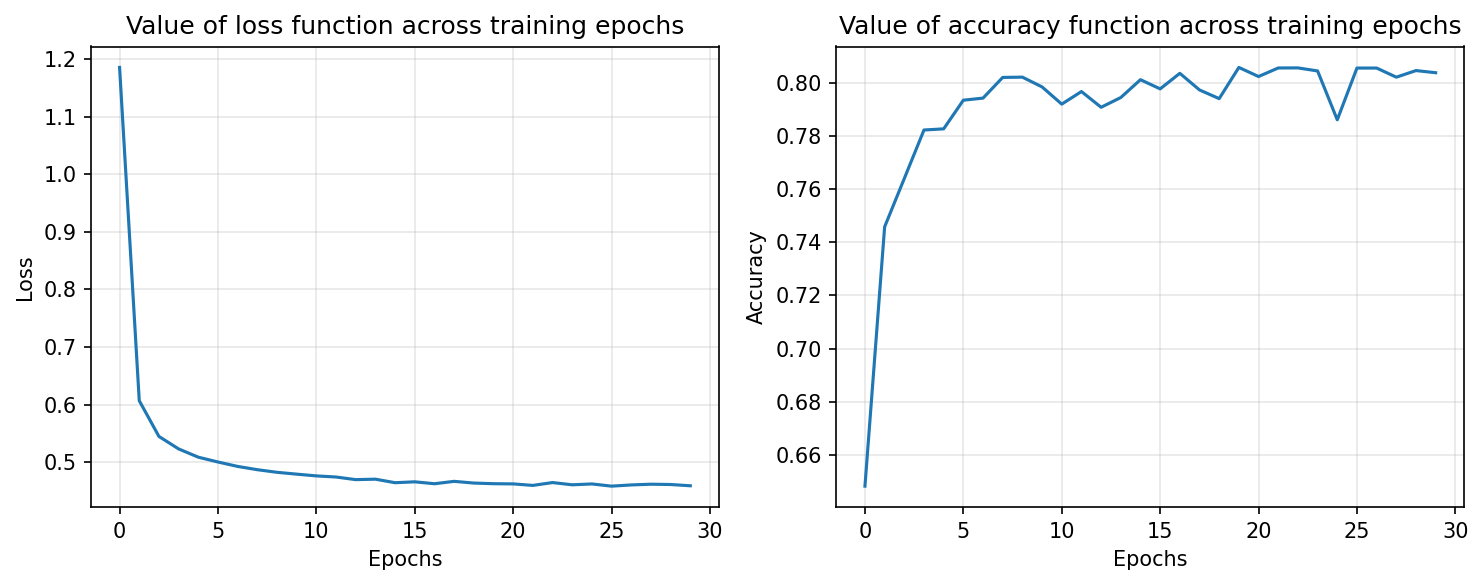

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

# Plot loss
axes[0].plot(history.history['loss'], label='loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Value of loss function across training epochs')
axes[0].grid(alpha=0.3)

# Plot accuracy
axes[1].plot(history.history['val_accuracy'], label='Value Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Value of accuracy function across training epochs')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

2909/2909 [==============================] - 3s 922us/step


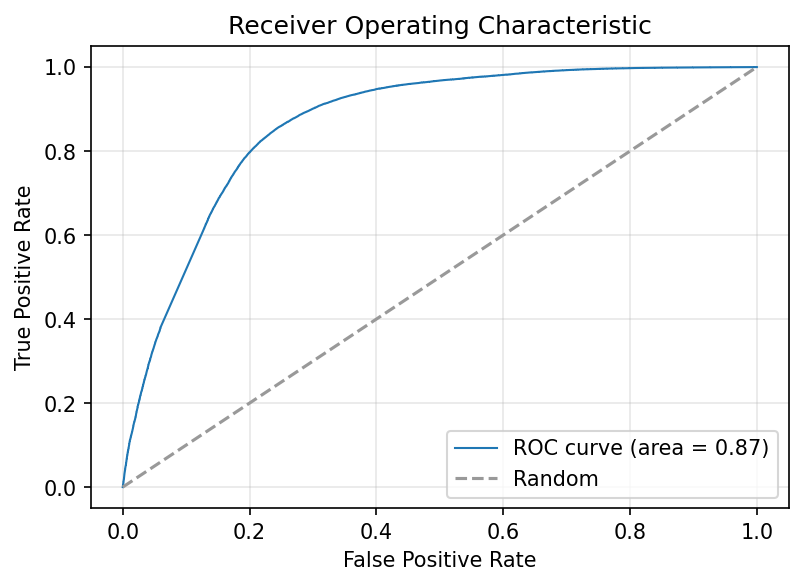

In [ ]:
# Evalute the classifier performance using some of thestandard metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Predict the test data
y_pred = model.predict(test_data)
fpr, tpr, thresholds = roc_curve(test_target, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure(dpi=150, figsize=(6, 4))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# predict the categories
predict_test_target = model.predict(test_data)
predicted = (predict_test_target > 0.5)

2909/2909 [==============================] - 3s 950us/step


In [ ]:
def heatmap(arr):
    plt.figure(dpi=100)
    arr = (arr.astype('float') / arr.sum(axis=1)[:, np.newaxis]).round(2)
    plt.imshow(arr, cmap=sns.light_palette('Green', as_cmap=True))

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    cbar = plt.colorbar()
    cbar.outline.set_visible(False)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for i in range(2):
        for j in range(2):
            # white text if the background is dark, black text if the background is light
            plt.text(j, i, arr[i, j], ha='center', va='center', color='black')

    plt.show()

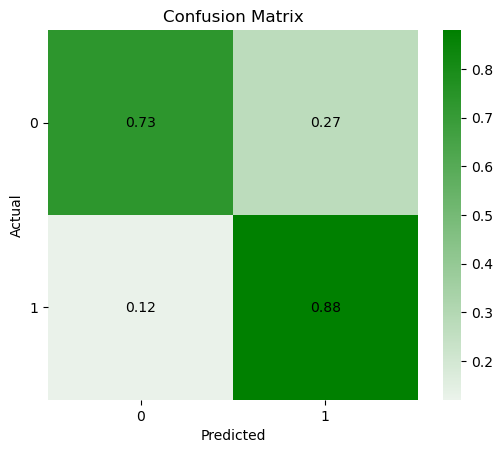

In [ ]:
sklearn_cm = confusion_matrix(test_target, predicted)
heatmap(sklearn_cm)

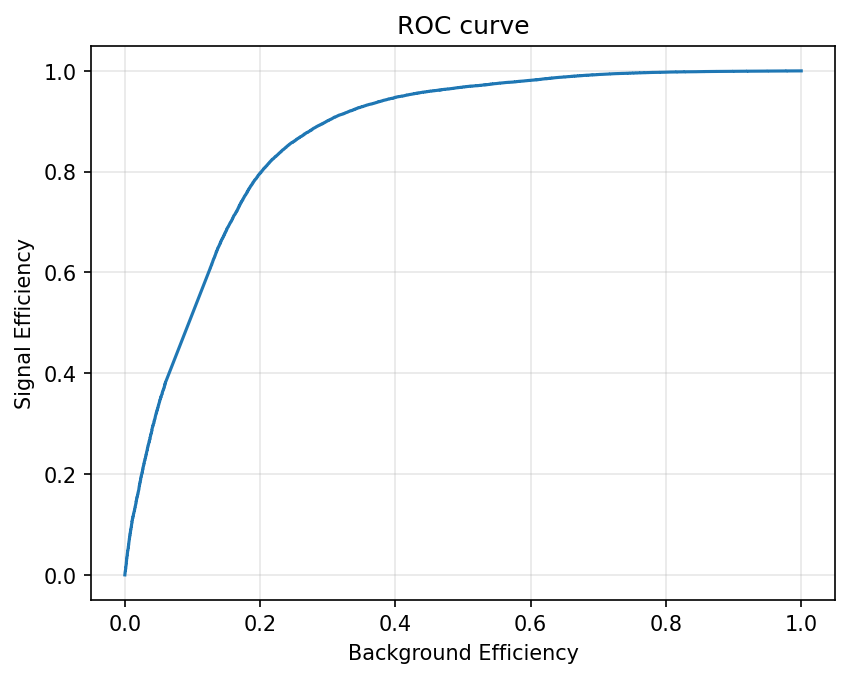

In [ ]:
roc_c = roc_curve(test_target, predict_test_target)

plt.figure(dpi=150)
plt.plot(roc_c[0], roc_c[1])
plt.xlabel('Background Efficiency') # False Positive Rate
plt.ylabel('Signal Efficiency') # True Positive Rate
plt.title('ROC curve')
plt.grid(alpha=0.3)
plt.show()